In [1]:
%load_ext autoreload
%autoreload 2
from numba import cuda 
device = cuda.get_current_device()
device.reset()


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sys
import os
from sklearn.preprocessing import LabelEncoder
import datetime

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.read_parallel import read_parallel_local


import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

In [3]:
import transformers
print (sys.version)
print(transformers.__version__)
print(tf.__version__)

3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
4.3.3
2.4.1


In [4]:
from src.models.deeplegis import legislationDataset, legislationDatasetText, legislationDatasetRevCat, legislationDatasetAll, legislationDatasetNoText
from src.models.deeplegis import deep_legis_text, deep_legis_pl, deep_legis_all, deep_legis_vn_cat, deep_legis_no_text

In [5]:
REDUCE_BY_FACTOR = 100 # Make the dataset smaller for development purposes
train_test_ratio = 0.91
train_valid_ratio = 0.90

if 'DATA_VOL' not in os.environ:
    # Manually set:
    DATA_VOL = '/datavol/'
else:
    DATA_VOL = os.environ['DATA_VOL']
    
# Pre-wrangled metadata
df = pd.read_csv("../references/derived/ml_data.csv", encoding="latin1", parse_dates=True)
df.id = df.id.astype(int)    
print(f"Original number of examples: {len(df)}")
df = df.sample(n=int(len(df)/REDUCE_BY_FACTOR)) #
print(f"Reduced number of examples:  {len(df)}")

tmp = read_parallel_local(df['id'], DATA_VOL + "/clean/")
df['text'] = tmp

df = df.reset_index(drop=True)
sc_id_encoder = LabelEncoder()
df['sc_id_cat'] = sc_id_encoder.fit_transform(df['sc_id'])

Original number of examples: 199646
Reduced number of examples:  1996
Took 0.00845481554667155 min to open 1996 files with 20 processes.


In [6]:
df.head()

,id,version_number,bill_id,signed,partisan_lean,sc_id,text,sc_id_cat
0,2709507,2,1156642,1,0.236118,562-1,senate state and local government committee am...,6
1,2465172,1,1258958,0,0.436937,601-2,"house bill no. december 2019, introduced by r...",66
2,2563745,1,1314677,0,0.691329,641-2,"assembly, no. state of new jersey 219th legisl...",122
3,2136531,1,1105336,0,0.625512,607-2,80th oregon legislative assembly-2019 regular...,72
4,2153696,1,1119564,0,0.626372,605-2,101st general assembly state of illinois and h...,70


In [7]:
with tf.device("/device:GPU:0"):
    # Partisan lean only
    
    config = {}
    config['max_length'] = 128
    config['train_batch_size'] = 4
    config['testing'] = False
    config['train_test_ratio'] = 0.91
    config['train_valid_ratio'] = 0.90
    config['n_sc_id_classes'] = len(sc_id_encoder.classes_)
    config['tokenizer'] = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
    
    epochs = 5
    legis_builder = legislationDataset(config)
    train_stream, val_stream, test_stream = legis_builder.create_batch_stream(df)
    
    dl_pl = deep_legis_pl(config)
    dl_pl.summary()
    dl_pl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
    log_dir = "../logs/fit/dl_pl_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='10, 15')
    # Create a callback that saves the model's weights
    checkpoint_path = "../models/dl_pl.ckpt"
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    history = dl_pl.fit(train_stream,
                   validation_data=val_stream,
                   epochs=epochs,
                    callbacks=[tensorboard_callback, cp_callback],
                   verbose=1)
    print(history)
    plot_graphs(history, 'loss')
    plot_graphs(history, 'binary_accuracy')

Training size: (16350, 8)
Validation size: (1817, 8)
Test size: (1797, 8)


Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerForSequenceClassification: ['lm_head']
- This IS expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFLongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
longformer (TFLongformerMainLay TFLongformerBaseMode 148068864   input_ids[0][0]                  
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           longformer[0][0]                 
__________________________________________________________________________________________________
dropout_50 (Dropout)            (None, 768)          0           tf.__operators__.getitem[0][0]   
______________________________________________________________________________________________

KeyboardInterrupt: 

In [13]:
with tf.device("/device:GPU:0"):
    # All metadata
    from transformers import LongformerTokenizer
    config = {}
    config['max_length'] = 128
    config['train_batch_size'] = 4
    config['testing'] = False
    config['train_test_ratio'] = 0.91
    config['train_valid_ratio'] = 0.90
    config['n_sc_id_classes'] = len(sc_id_encoder.classes_)
    config['tokenizer'] = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
    epochs = 5
    
    print(config)
    from src.models.deeplegis import legislationDatasetAll
    from src.models.deeplegis import deep_legis_all

    legis_builder = legislationDatasetAll(config)
    train_stream, val_stream, test_stream = legis_builder.create_batch_stream(df)
    dl_all = deep_legis_all(config)
    dl_all.summary()
    dl_all.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
    log_dir = "../logs/fit/dl_all_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='10, 15')
    checkpoint_path = "../models/dl_all.ckpt"
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    history = dl_all.fit(train_stream,
                   validation_data=val_stream,
                   epochs=epochs,
                    callbacks=[tensorboard_callback],
                   verbose=1)

    plot_graphs(history, 'loss')
    plot_graphs(history, 'binary_accuracy')

{'max_length': 128, 'train_batch_size': 8, 'testing': False, 'train_test_ratio': 0.91, 'train_valid_ratio': 0.9, 'n_sc_id_classes': 131, 'tokenizer': PreTrainedTokenizer(name_or_path='allenai/longformer-base-4096', vocab_size=50265, model_max_len=4096, is_fast=False, padding_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})}
Training si

Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerForSequenceClassification: ['lm_head']
- This IS expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFLongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(None, 131)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
longformer (TFLongformerMainLay TFLongformerBaseMode 148068864   input_ids[0][0]                  
__________________________________________________________________________________________________
tf.__operators__.getitem_4 (Sli (None, 768)          0           longformer[0][0]                 
__________________________________________________________________________________________________
dropout_258 (Dropout)           (None, 768)          0           tf.__operators__.getitem_4[0][0] 
________________________________________________________________________________

KeyboardInterrupt: 

{'max_length': 128, 'train_batch_size': 16, 'testing': False, 'train_test_ratio': 0.91, 'train_valid_ratio': 0.9, 'n_sc_id_classes': 127, 'tokenizer': PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})}
Training size: (1634, 8)
Validation size: (182, 8)
Test size: (180, 8)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_ids[0][0]                  
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           bert[0][0]                       
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 768)          0           tf.__operators__.getitem[0][0]   
______________________________________________________________________________________________

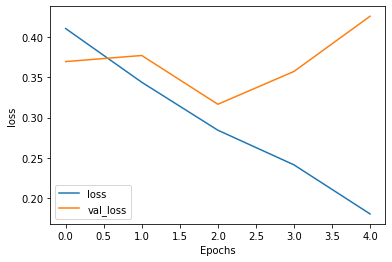

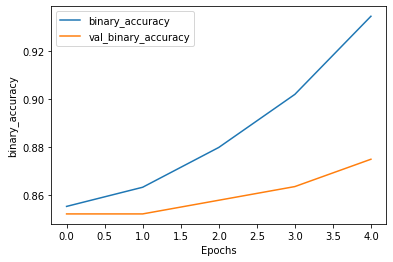

In [7]:
with tf.device("/device:GPU:0"):
    # All metadata -- BERT model
    from transformers import BertTokenizer
    from src.models.deeplegis import bert_all
    config = {}
    config['max_length'] = 128
    config['train_batch_size'] = 16
    config['testing'] = False
    config['train_test_ratio'] = 0.91
    config['train_valid_ratio'] = 0.90
    config['n_sc_id_classes'] = len(sc_id_encoder.classes_)
    config['tokenizer'] = BertTokenizer.from_pretrained('bert-base-uncased')

    epochs = 5
    
    print(config)
    from src.models.deeplegis import legislationDatasetAll
    from src.models.deeplegis import deep_legis_all

    legis_builder = legislationDatasetAll(config)
    train_stream, val_stream, test_stream = legis_builder.create_batch_stream(df)
    bert_all = bert_all(config)
    bert_all.summary()
    bert_all.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
    log_dir = "../logs/fit/bert_all_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='10, 15')
    checkpoint_path = "../models/bert_all.ckpt"
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    history = bert_all.fit(train_stream,
                   validation_data=val_stream,
                   epochs=epochs,
                   callbacks=[tensorboard_callback, cp_callback],
                   verbose=1)

    plot_graphs(history, 'loss')
    plot_graphs(history, 'binary_accuracy')

In [9]:
with tf.device("/device:GPU:0"):
    # Text only
    config = {}
    config['max_length'] = 128
    config['train_batch_size'] = 4
    config['testing'] = False
    config['train_test_ratio'] = 0.91
    config['train_valid_ratio'] = 0.90
    epochs = 2
    from src.models.deeplegis import legislationDatasetText
    from src.models.deeplegis import deep_legis_text

    legis_builder = legislationDatasetText(config)
    train_stream, val_stream, test_stream = legis_builder.create_batch_stream(df)
    dl_text = deep_legis_text(config)
    dl_text.summary()
    dl_text.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
    log_dir = "../logs/fit/dl_text_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='10, 15')

    history = dl_text.fit(train_stream,
                   validation_data=val_stream,
                   epochs=epochs,
                   callbacks=[tensorboard_callback],
                   verbose=1)
    print(history)
    plot_graphs(history, 'loss')
    plot_graphs(history, 'binary_accuracy')

[autoreload of src.models.deeplegis failed: Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/ubuntu/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/ubuntu/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/ubuntu/g

Training size: (1634, 8)
Validation size: (182, 8)
Test size: (180, 8)


Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerForSequenceClassification: ['lm_head']
- This IS expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFLongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

{'max_length': 128, 'train_batch_size': 4, 'testing': False, 'train_test_ratio': 0.91, 'train_valid_ratio': 0.9, 'n_sc_id_classes': 74}
Training size: (162, 8)
Validation size: (19, 8)
Test size: (18, 8)


Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerForSequenceClassification: ['lm_head']
- This IS expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFLongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(None, 74)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
longformer (TFLongformerMainLay TFLongformerBaseMode 148068864   input_ids[0][0]                  
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           longformer[0][0]                 
__________________________________________________________________________________________________
dropout_51 (Dropout)            (None, 768)          0           tf.__operators__.getitem[0][0]   
_________________________________________________________________________________

KeyboardInterrupt: 

In [68]:
with tf.device("/device:GPU:0"):
    # text, version number, sc-id
    config = {}
    config['max_length'] = 128
    config['train_batch_size'] = 4
    config['testing'] = False
    config['train_test_ratio'] = 0.91
    config['train_valid_ratio'] = 0.90
    config['n_sc_id_classes'] = len(sc_id_encoder.classes_)

    from src.models.deeplegis import legislationDatasetRevCat
    legis_builder = legislationDatasetRevCat(config)
    train_stream, val_stream, test_stream = legis_builder.create_batch_stream(df)
    from src.models.deeplegis import deep_legis_vn_cat
    dl_vn_cat = deep_legis_vn_cat(config)
    dl_vn_cat.summary()
    dl_vn_cat.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
    log_dir = "../logs/fit/dl_vn_cat_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='10, 15')

    history = dl_vn_cat.fit(train_stream,
                   validation_data=val_stream,
                   epochs=epochs,
                    callbacks=[tensorboard_callback],
                   verbose=1)

    plot_graphs(history, 'loss')
    plot_graphs(history, 'binary_accuracy')

{'max_length': 128, 'train_batch_size': 32, 'testing': False, 'train_test_ratio': 0.91, 'train_valid_ratio': 0.9, 'n_sc_id_classes': 70}
Training size: (162, 8)
Validation size: (19, 8)
Test size: (18, 8)
({'input_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[    0,  1437,  1437, ..., 38187,   102,     2],
       [    0,  5615,   937, ...,  4484,     9,     2],
       [    0,   627, 22437, ...,   899,     7,     2],
       ...,
       [    0,  7305,   877, ...,  4458,     6,     2],
       [    0,   194,     9, ...,     6,   109,     2],
       [    0,  2914,  1707, ...,    12, 10224,     2]], dtype=int32)>, 'version_number': <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([1., 2., 1., 2., 2., 1., 1., 2., 1., 1., 5., 1., 2., 1., 3., 2., 2.,
       1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 4., 1., 2., 1.],
      dtype=float32)>, 'sc_ids': <tf.Tensor: shape=(32, 1, 70), dtype=int32, numpy=
array([[[0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0]],

     

{'max_length': 128, 'train_batch_size': 4, 'testing': False, 'train_test_ratio': 0.91, 'train_valid_ratio': 0.9, 'n_sc_id_classes': 74}
Training size: (162, 8)
Validation size: (19, 8)
Test size: (18, 8)
(None, 74)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
partisan_lean (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
version_number (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
sc_id (InputLayer)              [(None, 74)]         0                                            
_____________________________________________________________________________

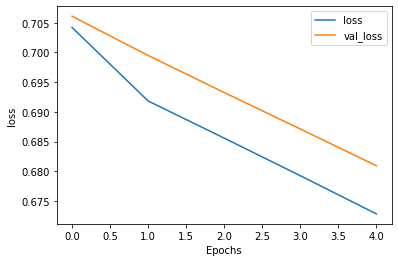

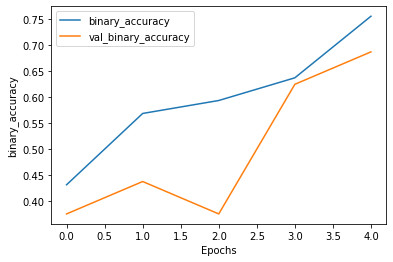

In [7]:
# No text at all, reference model
with tf.device("/device:GPU:0"):
    epochs = 5
    config = {}
    config['max_length'] = 128
    config['train_batch_size'] = 4
    config['testing'] = False
    config['train_test_ratio'] = 0.91
    config['train_valid_ratio'] = 0.90
    config['n_sc_id_classes'] = len(sc_id_encoder.classes_)
    print(config)
    from src.models.deeplegis import legislationDatasetNoText
    legis_builder = legislationDatasetNoText(config)
    train_stream, val_stream, test_stream = legis_builder.create_batch_stream(df)

    from src.models.deeplegis import deep_legis_no_text
    dl_no_text = deep_legis_no_text(config)
    dl_no_text.summary()
    dl_no_text.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])

    log_dir = "../logs/fit/dl_no_text_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='10, 15')

    history = dl_no_text.fit(train_stream,
                   validation_data=val_stream,
                   epochs=epochs,
                    callbacks=[tensorboard_callback],
                   verbose=1)

    plot_graphs(history, 'loss')
    plot_graphs(history, 'binary_accuracy')